<a href="https://colab.research.google.com/github/prasadanvekar/elvtrdocs/blob/main/Asssignment8_Financial_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install the Yahoo finance package and pmdarima package
!pip install yfinance pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.1 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


-------Raw Data-------
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.977480  270597600
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.376616  223164000
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.919144  273829600
2016-01-07  24.670000  25.032499  24.107500  24.112499  21.951849  324377600
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.067924  283192000
-------Engineered Data-------
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.977480  270597600   
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.376616  223164000   
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.919144  273829600   
2016-01-

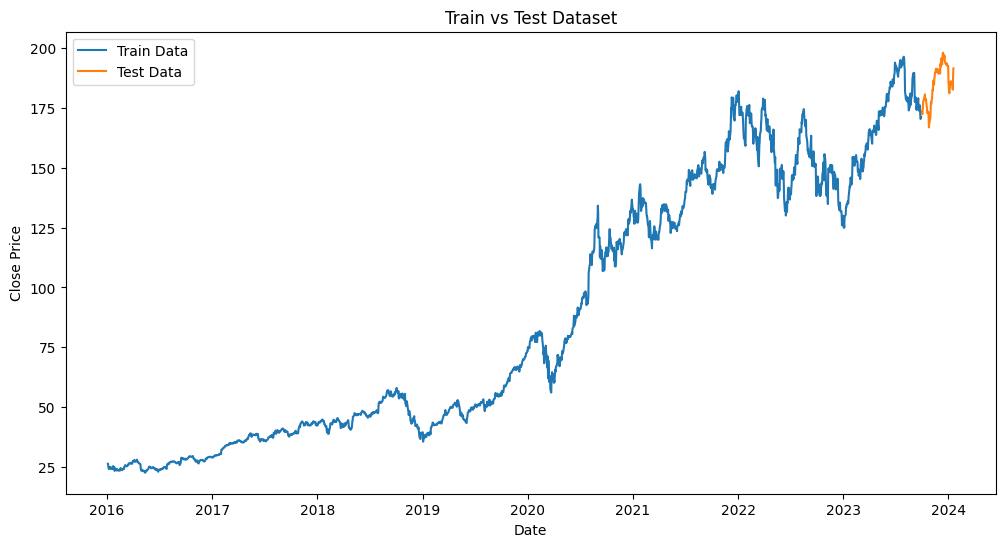

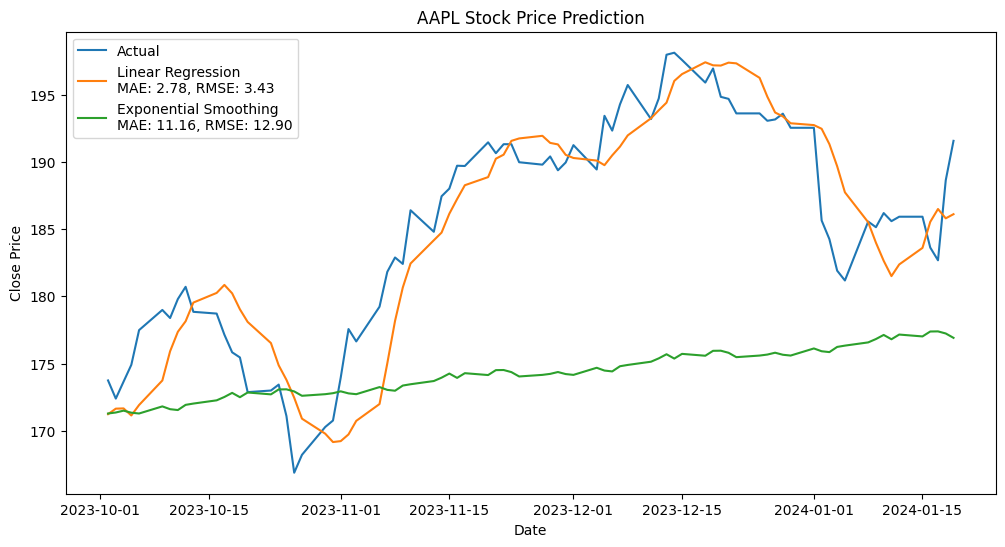

Linear Regression Metrics:
MAE: 2.78
MSE: 11.79
RMSE: 3.43

Exponential Smoothing Metrics:
MAE: 11.16
MSE: 166.53
RMSE: 12.90

ARIMA Model Metrics:
MAE: 11.35
MSE: 171.65
RMSE: 13.10


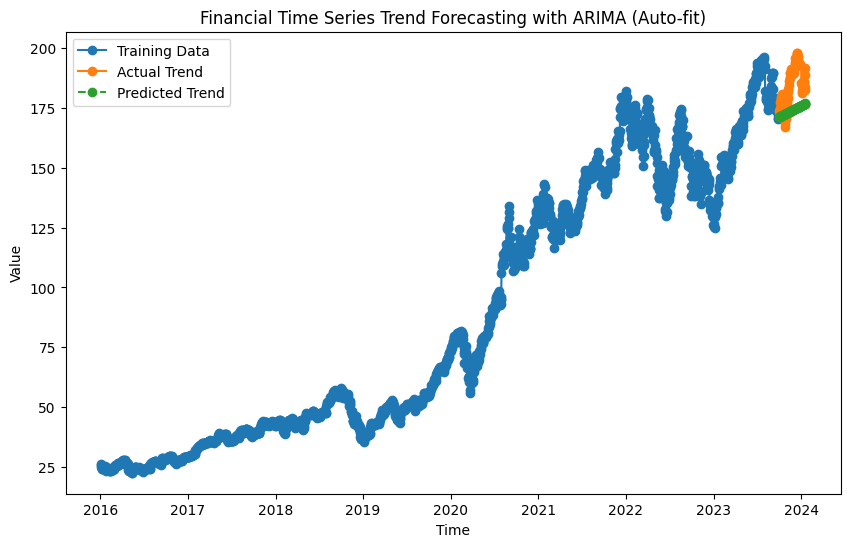

In [45]:
#################################################################################
# Assignment 8 Objective:construct predictive models using linear regression    #
#and exponential smoothing, assess the models' performance using various metrics#
# Author:  Prasad S Anvekar                                                     #
# Date:  22 Jan 2024                                                            #
#################################################################################
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

# Data Acquisition
ticker = 'AAPL'
stock_data = yf.download('AAPL', start='2016-01-01', end='2024-01-21')
stock_data.sort_index(ascending=True, inplace=True)

# Ensure proper DatetimeIndex with frequency for time series analysis
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B', method='ffill')

print('-------Raw Data-------')
print(stock_data.head())

# Calculate rolling averages
stock_data['7_day_avg'] = stock_data['Close'].rolling(window=7, min_periods=1).mean()
stock_data['30_day_avg'] = stock_data['Close'].rolling(window=10, min_periods=1).mean()

print('-------Engineered Data-------')
print(stock_data.head())
print(stock_data.describe())

# Feature engineering
stock_data['7_day_shifted'] = stock_data['7_day_avg'].shift(1)
stock_data['30_day_shifted'] = stock_data['30_day_avg'].shift(1)

# Split the data into training and test sets
split_date = pd.to_datetime('2023-10-01')
train = stock_data.loc[stock_data.index < split_date]
test = stock_data.loc[stock_data.index >= split_date]

# Prepare the training and test data for Linear Regression
X_train = train[['7_day_shifted','30_day_shifted']].dropna()
y_train = train['Close'][1:].values
X_test = test[['7_day_shifted','30_day_shifted']].dropna()
y_test = test['Close']

# Review is the data size
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Visualization of Train and Test Datasets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Train Data')
plt.plot(test.index, test['Close'], label='Test Data')
plt.title('Train vs Test Dataset')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Fit a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict the trend for the test set
reg_predictions = model_lr.predict(X_test)

# Exponential Smoothing model

window_size = 20
exp_model = ExponentialSmoothing(train['Close'], trend='add', seasonal='add', seasonal_periods=window_size)
exp_fit = exp_model.fit()
exp_predictions = exp_fit.forecast(len(test))

# Evaluation metrics
reg_mae = mean_absolute_error(y_test, reg_predictions)
reg_mse = mean_squared_error(y_test, reg_predictions)
reg_rmse = np.sqrt(reg_mse)

exp_mae = mean_absolute_error(y_test, exp_predictions)
exp_mse = mean_squared_error(y_test, exp_predictions)
exp_rmse = np.sqrt(exp_mse)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, reg_predictions, label=f'Linear Regression\nMAE: {reg_mae:.2f}, RMSE: {reg_rmse:.2f}')
plt.plot(test.index, exp_predictions, label=f'Exponential Smoothing\nMAE: {exp_mae:.2f}, RMSE: {exp_rmse:.2f}')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Performance metrics
print(f'Linear Regression Metrics:\nMAE: {reg_mae:.2f}\nMSE: {reg_mse:.2f}\nRMSE: {reg_rmse:.2f}')
print(f'\nExponential Smoothing Metrics:\nMAE: {exp_mae:.2f}\nMSE: {exp_mse:.2f}\nRMSE: {exp_rmse:.2f}')

# Auto-fit ARIMA model
auto_model = auto_arima(train['Close'], seasonal=False, suppress_warnings=True)
fit_model = auto_model.fit(train['Close'])

# Forecast the trend for the test set
forecast = fit_model.predict(n_periods=len(test))

# Calculate performance metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'\nARIMA Model Metrics:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}')

# Plot the actual and predicted trends
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close'], label='Training Data', marker='o')
plt.plot(test.index, test['Close'], label='Actual Trend', marker='o')
plt.plot(test.index, forecast, label='Predicted Trend', linestyle='--', marker='o')
plt.title('Financial Time Series Trend Forecasting with ARIMA (Auto-fit)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



**Model Performance Metrics**

**Linear Regression Metrics:**
MAE (Mean Absolute Error): 2.78
MSE (Mean Squared Error): 11.79
RMSE (Root Mean Squared Error): 3.43

**Exponential Smoothing Metrics:**
MAE (Mean Absolute Error): 11.16
MSE (Mean Squared Error): 166.53
RMSE (Root Mean Squared Error): 12.90

**ARIMA Model Metrics:**
MAE (Mean Absolute Error): 11.35
MSE (Mean Squared Error): 171.65
RMSE (Root Mean Squared Error): 13.10


# Interpretation of the Performance Metrics

**Linear Regression Model:**
The Linear Regression model exhibits the lowest MAE, MSE, and RMSE among the three models. This suggests that, based on the provided metrics, the Linear Regression model outperforms both the Exponential Smoothing and ARIMA models in terms of prediction accuracy. The simplicity and interpretability of linear regression might have contributed to its effectiveness in capturing the underlying patterns in the stock price data.

**Exponential Smoothing Model:**
The Exponential Smoothing model shows higher MAE, MSE, and RMSE compared to Linear Regression. This indicates that the model might struggle to capture the variability and trends present in the Apple stock prices. The inherent flexibility of Exponential Smoothing might not have been sufficient to model the complex patterns in the data effectively.

**ARIMA Model:**
The ARIMA model performs similarly to Exponential Smoothing in terms of MAE, MSE, and RMSE. Both models demonstrate higher errors compared to Linear Regression. ARIMA models are designed to capture time-dependent structures in the data, but their performance may be affected by the complexity and non-linearity of financial time series.


**Potential Reasons for Differences in Performance**
**Model Assumptions:**

Linear Regression assumes a linear relationship between features and the target variable. If the relationship is indeed linear, it can perform well.
Exponential Smoothing and ARIMA models are designed for time series data and may perform better when there are clear trends and seasonality.

**Complexity of Data:**

Financial time series data often involves complex and non-linear patterns. Linear Regression might struggle to capture such intricacies, leading to its superior performance.

**Flexibility of Models:**

Exponential Smoothing and ARIMA models offer more flexibility in capturing time-dependent structures, but this flexibility might lead to overfitting or underfitting, especially in the presence of noise.

**Conlcusion:**

The performance metrics of forecasting models have direct implications for decision-making in finance. Accurate predictions are crucial for risk management, trading strategies, investment decisions, and efficient resource allocation. The choice of a forecasting model should be aligned with the specific goals and characteristics of the financial data being analyzed. Continuous monitoring and adaptation of models are key to navigating the dynamic nature of financial markets.

The above data analysis highlights the importance of understanding the nature of the data and selecting models that align with its complexities.

*   The choice of the best model depends on the specific characteristics of the data and the goals of the forecasting task.
*   Linear Regression, with its simplicity and interpretability, can be a suitable choice for relatively straightforward relationships in financial time series.
*   More advanced models like Exponential Smoothing and ARIMA may need fine-tuning of parameters and feature engineering to better capture the underlying patterns in the data.





